In [0]:
import pandas as pd
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from  sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from  sklearn.metrics import *
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn import model_selection
import plotly.express as px
import plotly.graph_objects as go
import pickle

In [2]:
!pip install rfpimp
import rfpimp

     |████████████████████████████████| 153kB 3.8MB/s 
  Created wheel for rfpimp: filename=rfpimp-1.3.5-cp36-none-any.whl size=10260 sha256=e0cea350dfb6b34c58d9713d4ed199bc96dd9cbe187b6a04fa24566323c0dfeb
  Stored in directory: /root/.cache/pip/wheels/2a/c8/bf/80f91224be00870f84a85aa1782cf6cd62c1289a173b66b8e9
  Created wheel for stratx: filename=stratx-0.3-cp36-none-any.whl size=22699 sha256=7221de044548bb6ed76106520127c438fd9c42acccf1bef885306b5e42344ee0
  Stored in directory: /root/.cache/pip/wheels/91/3b/c3/9dcafed446985efb9008de84b720ddf003ac963e6807e8ad15
Successfully built rfpimp stratx


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.



# Load Data

In [3]:
!wget https://www.attax.at/clean.csv

--2020-06-07 18:46:01--  https://www.attax.at/clean.csv
Resolving www.attax.at (www.attax.at)... 213.145.224.160
Connecting to www.attax.at (www.attax.at)|213.145.224.160|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4519661 (4.3M) [text/csv]
Saving to: ‘clean.csv’

clean.csv           100%[===================>]   4.31M  3.37MB/s    in 1.3s    

2020-06-07 18:46:03 (3.37 MB/s) - ‘clean.csv’ saved [4519661/4519661]



In [0]:
df = pd.read_csv("clean.csv")

In [5]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,0,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,0,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,0,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,0,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,0,1.1,93.994,-36.4,4.857,5191.0,no


# Feature Exploration

## Overall Statistic

Let's calculate basic statistical features for all columns

In [6]:
for column in df.columns:
    print('Statistic for:', column)
    print(df[column].describe())
    print('---------------------')

Statistic for: age
count    41176.00000
mean        40.02380
std         10.42068
min         17.00000
25%         32.00000
50%         38.00000
75%         47.00000
max         98.00000
Name: age, dtype: float64
---------------------
Statistic for: job
count      41176
unique        11
top       admin.
freq       10749
Name: job, dtype: object
---------------------
Statistic for: marital
count       41176
unique          3
top       married
freq        25001
Name: marital, dtype: object
---------------------
Statistic for: education
count                 41176
unique                    7
top       university.degree
freq                  13894
Name: education, dtype: object
---------------------
Statistic for: default
count     41176
unique        3
top          no
freq      32577
Name: default, dtype: object
---------------------
Statistic for: housing
count     41176
unique        2
top         yes
freq      22561
Name: housing, dtype: object
---------------------
Statistic for: loan

# **Correlation between numerical Features**



In [0]:
correlation_matrix = df.corr()

In [8]:
correlation_matrix

,age,duration,campaign,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
age,1.000000,-0.000808,0.004622,0.024379,-0.000242,0.001009,0.129075,0.010852,-0.017607
duration,-0.000808,1.000000,-0.071765,0.020600,-0.027941,0.005303,-0.008126,-0.032861,-0.044672
campaign,0.004622,-0.071765,1.000000,-0.079182,0.150786,0.127826,-0.013657,0.135169,0.144129
previous,0.024379,0.020600,-0.079182,1.000000,-0.420587,-0.203197,-0.050929,-0.454571,-0.501411
emp_var_rate,-0.000242,-0.027941,0.150786,-0.420587,1.000000,0.775293,0.196257,0.972244,0.906949
cons_price_idx,0.001009,0.005303,0.127826,-0.203197,0.775293,1.000000,0.059170,0.688180,0.521945
cons_conf_idx,0.129075,-0.008126,-0.013657,-0.050929,0.196257,0.059170,1.000000,0.277864,0.100679
euribor3m,0.010852,-0.032861,0.135169,-0.454571,0.972244,0.688180,0.277864,1.000000,0.945146
nr_employed,-0.017607,-0.044672,0.144129,-0.501411,0.906949,0.521945,0.100679,0.945146,1.000000


In [9]:
fig = go.Figure(data=go.Heatmap(x=correlation_matrix.columns, y=correlation_matrix.columns,z=correlation_matrix))
fig.show()

**Relation between 'nr_employed' and 'euribor3m':**


From the correlation matrix, we can see that there is a relatively high correlation between 'nr_employed' and 'euribor3m' and vice versa, so both social economic indicators.

In [10]:
fig = px.histogram(y=df.nr_employed, x=df.euribor3m)
fig.show()

**Result:**
It seems that the higher the 3-months-Euribor-rate (interest rate) ist, the more citizens are employed.

# **Univariate analysis**



**What is the proportion of married people?**

In [11]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'previous',
       'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m',
       'nr_employed', 'y'],
      dtype='object')

In [12]:
df.marital.value_counts()

married     25001
single      11564
divorced     4611
Name: marital, dtype: int64

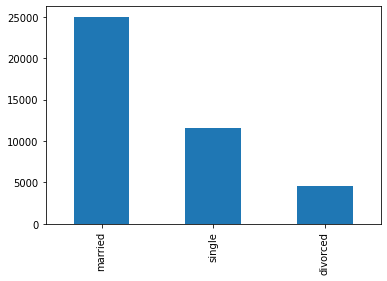

In [13]:
df.marital.value_counts().plot(kind="bar")

In [0]:
total_people_count = df.shape[0]

In [0]:
married_people_count = df[df.marital=="married"].shape[0]

In [16]:
married_people_count / total_people_count

0.6071740819895084

**60,7 % are married.**

**Which is the most common job among all contacted people?**

In [17]:
df.job.value_counts()

admin.           10749
blue-collar       9253
technician        6739
services          3967
management        2924
retired           1718
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
Name: job, dtype: int64

In [0]:
admin_people_count = df[df.job=="admin."].shape[0]

In [19]:
admin_people_count / total_people_count

0.26105012628715757

**The most common job is in administration. 26,1 % of all contacted people work in this field.**

**Distribution of age**



In [20]:
fig = px.histogram(df, x="age")
fig.show()

# **Bivariate analysis**

**Is there a relationship beetween the duration of the calls and the outcome (succesfully selling a term deposit)?**

In [21]:
df.groupby("y").mean()

,age,duration,campaign,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
y,,,,,,,,,
no,39.910994,220.868079,2.633385,0.132414,0.248885,93.603798,-40.593232,3.811482,5176.165690
yes,40.912266,553.256090,2.051951,0.492779,-1.233089,93.354577,-39.791119,2.123362,5095.120069


In [22]:
df.groupby("y").mean().reset_index()

,y,age,duration,campaign,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
0,no,39.910994,220.868079,2.633385,0.132414,0.248885,93.603798,-40.593232,3.811482,5176.165690
1,yes,40.912266,553.256090,2.051951,0.492779,-1.233089,93.354577,-39.791119,2.123362,5095.120069


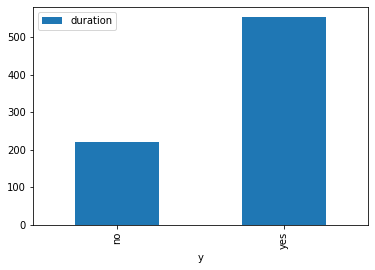

In [23]:
df.groupby("y").mean().reset_index().plot.bar("y", "duration")

The average duration of the call were **no** term deposit was sold is 220 sec, where as the successful agents took 553 sec per (possible) customer. So there is a strong relationship between the duration of the call and the outcome. 

**How about education, do people with higher education more likely make a term deposit?**

In [0]:
df_education = df.groupby( ["education","y"])["default"].count().reset_index()

In [25]:
df_education

,education,y,default
0,basic.4y,no,3748
1,basic.4y,yes,428
2,basic.6y,no,2103
3,basic.6y,yes,188
4,basic.9y,no,5572
5,basic.9y,yes,473
6,high.school,no,8481
7,high.school,yes,1031
8,illiterate,no,14
9,illiterate,yes,4


In [0]:
df_education.sort_values(by=['default'],ascending=False, inplace=True)

In [27]:
df_education

,education,y,default
12,university.degree,no,11974
6,high.school,no,8481
4,basic.9y,no,5572
10,professional.course,no,4645
0,basic.4y,no,3748
2,basic.6y,no,2103
13,university.degree,yes,1920
7,high.school,yes,1031
11,professional.course,yes,595
5,basic.9y,yes,473


In [28]:
px.bar(df_education, y="default", x="education", color="y", barmode="stack")

**Verifying the visual impression we got from the chart - what are the relative values for 'university.degree' and 'high.school'?**

In [0]:
df_rel_education = df.groupby( ["education", "y"])["default"].count()

In [30]:
df_rel_education

education            y  
basic.4y             no      3748
                     yes      428
basic.6y             no      2103
                     yes      188
basic.9y             no      5572
                     yes      473
high.school          no      8481
                     yes     1031
illiterate           no        14
                     yes        4
professional.course  no      4645
                     yes      595
university.degree    no     11974
                     yes     1920
Name: default, dtype: int64

In [31]:
df_rel_education["high.school"]/df_rel_education["high.school"].sum()

y
no     0.891611
yes    0.108389
Name: default, dtype: float64

In [32]:
df_rel_education["university.degree"]/df_rel_education["university.degree"].sum()

y
no     0.861811
yes    0.138189
Name: default, dtype: float64

**So, it is definite: 13.8 % of called people with university degree made the term deposit, followed by 10.8 % of called poeple who finished high school.**

*Just for fun - another method:*

In [33]:
df_temp = df.groupby(["education","y",])["default"].count()
for first_index in df.education.unique():
    for second_index in df[df.y == first_index].y.unique():
        df_temp.loc[first_index, second_index] /= df_temp.loc[first_index, second_index].sum()
df_temp[:,:]

education            y  
basic.4y             no      3748
                     yes      428
basic.6y             no      2103
                     yes      188
basic.9y             no      5572
                     yes      473
high.school          no      8481
                     yes     1031
illiterate           no        14
                     yes        4
professional.course  no      4645
                     yes      595
university.degree    no     11974
                     yes     1920
Name: default, dtype: int64

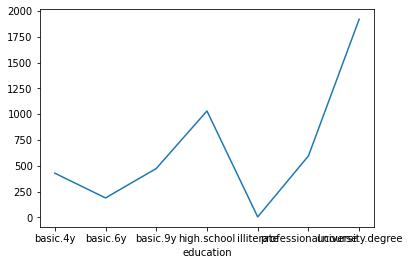

In [34]:
df_temp.loc[:,"yes"].plot()

**Which is the most succesfull day of the week to call?**

In [0]:
df_day = df.groupby( [ "y", "day_of_week",])["default"].count()

In [36]:
df_day

y    day_of_week
no   fri            6980
     mon            7665
     thu            7574
     tue            7133
     wed            7185
yes  fri             846
     mon             847
     thu            1044
     tue             953
     wed             949
Name: default, dtype: int64

In [0]:
df_rel_day = df_day / df_day.sum()

In [38]:
df_rel_day["yes"] / df_rel_day.sum()

day_of_week
fri    0.020546
mon    0.020570
thu    0.025355
tue    0.023145
wed    0.023047
Name: default, dtype: float64

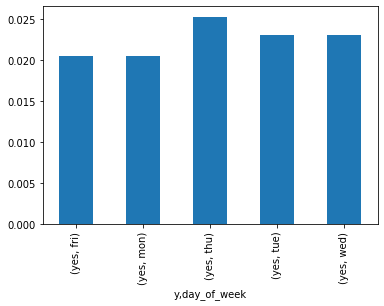

In [39]:
df_rel_day.loc["yes",:].plot.bar("y", "day_of_week")

In [0]:
df_rel_day = df_rel_day.reset_index()

In [41]:
df_rel_day

,y,day_of_week,default
0,no,fri,0.169516
1,no,mon,0.186152
2,no,thu,0.183942
3,no,tue,0.173232
4,no,wed,0.174495
5,yes,fri,0.020546
6,yes,mon,0.020570
7,yes,thu,0.025355
8,yes,tue,0.023145
9,yes,wed,0.023047


In [42]:
px.bar(df_rel_day[df_rel_day.y =="yes"], y = "default", x="day_of_week", color="day_of_week", orientation="v").update_xaxes(categoryorder="total descending")

**Result: The most successful day to call is Thursday, where 2.53 % of all called people make a term deposit.**

# Encoding Categorical Data

In [43]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'previous',
       'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m',
       'nr_employed', 'y'],
      dtype='object')

In [44]:
df.default.value_counts()

no         32577
unknown     8596
yes            3
Name: default, dtype: int64

**Dropping feature "default", since a high percentage is 'unknown'.**

In [45]:
df.shape

(41176, 19)

In [0]:
df = df.drop(labels='default', axis=1)

In [47]:
df.shape

(41176, 18)

In [48]:
df.housing.value_counts()

yes    22561
no     18615
Name: housing, dtype: int64

In [49]:
df.loan.value_counts()

no     34928
yes     6248
Name: loan, dtype: int64

In [50]:
df.campaign.value_counts()

1     17634
2     10568
3      5340
4      2650
5      1599
6       979
7       629
8       400
9       283
10      225
11      177
12      125
13       92
14       69
17       58
15       51
16       51
18       33
20       30
19       26
21       24
22       17
23       16
24       15
27       11
29       10
25        8
26        8
28        8
30        7
31        7
35        5
33        4
32        4
34        3
40        2
42        2
43        2
37        1
39        1
41        1
56        1
Name: campaign, dtype: int64

The feature 'campaign' is regarded as nominal data, since this feature contains the different campaigns. They could also be labelled with code names instead of numbers.

In [51]:
df.previous.value_counts()

0    35551
1     4561
2      754
3      216
4       70
5       18
6        5
7        1
Name: previous, dtype: int64

The feature 'previous' is regarded as numerical data, since this feature counts the number of the previous calls.

**These are the categorical colums:**

In [0]:
categorical_columns = ["job", "marital", "education", "housing", "loan", "contact", "day_of_week", "month", "campaign", "y"]

**Set Datatype of Ordinal/Nominal Variables to Category**

In [0]:
for col in categorical_columns:
    df[col] = df[col].astype('category')

**Create One Hot Encoding Features for the Categorical Variables**

In [0]:
df = pd.get_dummies(df, drop_first=True)

In [55]:
df.head()

,age,duration,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_married,marital_single,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,housing_yes,loan_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,...,campaign_4,campaign_5,campaign_6,campaign_7,campaign_8,campaign_9,campaign_10,campaign_11,campaign_12,campaign_13,campaign_14,campaign_15,campaign_16,campaign_17,campaign_18,campaign_19,campaign_20,campaign_21,campaign_22,campaign_23,campaign_24,campaign_25,campaign_26,campaign_27,campaign_28,campaign_29,campaign_30,campaign_31,campaign_32,campaign_33,campaign_34,campaign_35,campaign_37,campaign_39,campaign_40,campaign_41,campaign_42,campaign_43,campaign_56,y_yes
0,56,261,0,1.1,93.994,-36.4,4.857,5191.0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,57,149,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,37,226,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,40,151,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,56,307,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [56]:
df.shape

(41176, 84)

**Rename Last Column to y**

In [57]:
df.columns.tolist()

['age',
 'duration',
 'previous',
 'emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx',
 'euribor3m',
 'nr_employed',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'marital_married',
 'marital_single',
 'education_basic.6y',
 'education_basic.9y',
 'education_high.school',
 'education_illiterate',
 'education_professional.course',
 'education_university.degree',
 'housing_yes',
 'loan_yes',
 'contact_telephone',
 'month_aug',
 'month_dec',
 'month_jul',
 'month_jun',
 'month_mar',
 'month_may',
 'month_nov',
 'month_oct',
 'month_sep',
 'day_of_week_mon',
 'day_of_week_thu',
 'day_of_week_tue',
 'day_of_week_wed',
 'campaign_2',
 'campaign_3',
 'campaign_4',
 'campaign_5',
 'campaign_6',
 'campaign_7',
 'campaign_8',
 'campaign_9',
 'campaign_10',
 'campaign_11',
 'campaign_12',
 'campaign_13',
 'campaign_14',
 'campaign_15',
 'campaign_16',
 'ca

In [0]:
df.columns = list(df.columns.values[:-1]) + ["y"]

In [59]:
df.columns.tolist()

['age',
 'duration',
 'previous',
 'emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx',
 'euribor3m',
 'nr_employed',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'marital_married',
 'marital_single',
 'education_basic.6y',
 'education_basic.9y',
 'education_high.school',
 'education_illiterate',
 'education_professional.course',
 'education_university.degree',
 'housing_yes',
 'loan_yes',
 'contact_telephone',
 'month_aug',
 'month_dec',
 'month_jul',
 'month_jun',
 'month_mar',
 'month_may',
 'month_nov',
 'month_oct',
 'month_sep',
 'day_of_week_mon',
 'day_of_week_thu',
 'day_of_week_tue',
 'day_of_week_wed',
 'campaign_2',
 'campaign_3',
 'campaign_4',
 'campaign_5',
 'campaign_6',
 'campaign_7',
 'campaign_8',
 'campaign_9',
 'campaign_10',
 'campaign_11',
 'campaign_12',
 'campaign_13',
 'campaign_14',
 'campaign_15',
 'campaign_16',
 'ca

# Split Input Data and Output Data (Target Value)

In [0]:
X = df[df.columns[:-1]]
y = df[["y"]]

In [61]:
df.columns[-1:]

Index(['y'], dtype='object')

In [62]:
df[["y"]]

,y
0,0
1,0
2,0
3,0
4,0
...,...
41171,1
41172,0
41173,0
41174,1


In [63]:
y

,y
0,0
1,0
2,0
3,0
4,0
...,...
41171,1
41172,0
41173,0
41174,1


In [64]:
X

,age,duration,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_married,marital_single,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,housing_yes,loan_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,...,campaign_3,campaign_4,campaign_5,campaign_6,campaign_7,campaign_8,campaign_9,campaign_10,campaign_11,campaign_12,campaign_13,campaign_14,campaign_15,campaign_16,campaign_17,campaign_18,campaign_19,campaign_20,campaign_21,campaign_22,campaign_23,campaign_24,campaign_25,campaign_26,campaign_27,campaign_28,campaign_29,campaign_30,campaign_31,campaign_32,campaign_33,campaign_34,campaign_35,campaign_37,campaign_39,campaign_40,campaign_41,campaign_42,campaign_43,campaign_56
0,56,261,0,1.1,93.994,-36.4,4.857,5191.0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,57,149,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,37,226,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,40,151,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,56,307,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41171,73,334,0,-1.1,94.767,-50.8,1.028,4963.6,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41172,46,383,0,-1.1,94.767,-50.8,1.028,4963.6,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41173,56,189,0,-1.1,94.767,-50.8,1.028,4963.6,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41174,44,442,0,-1.1,94.767,-50.8,1.028,4963.6,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Decision Tree

In [0]:
model = DecisionTreeClassifier()

In [66]:
model.fit(X,y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

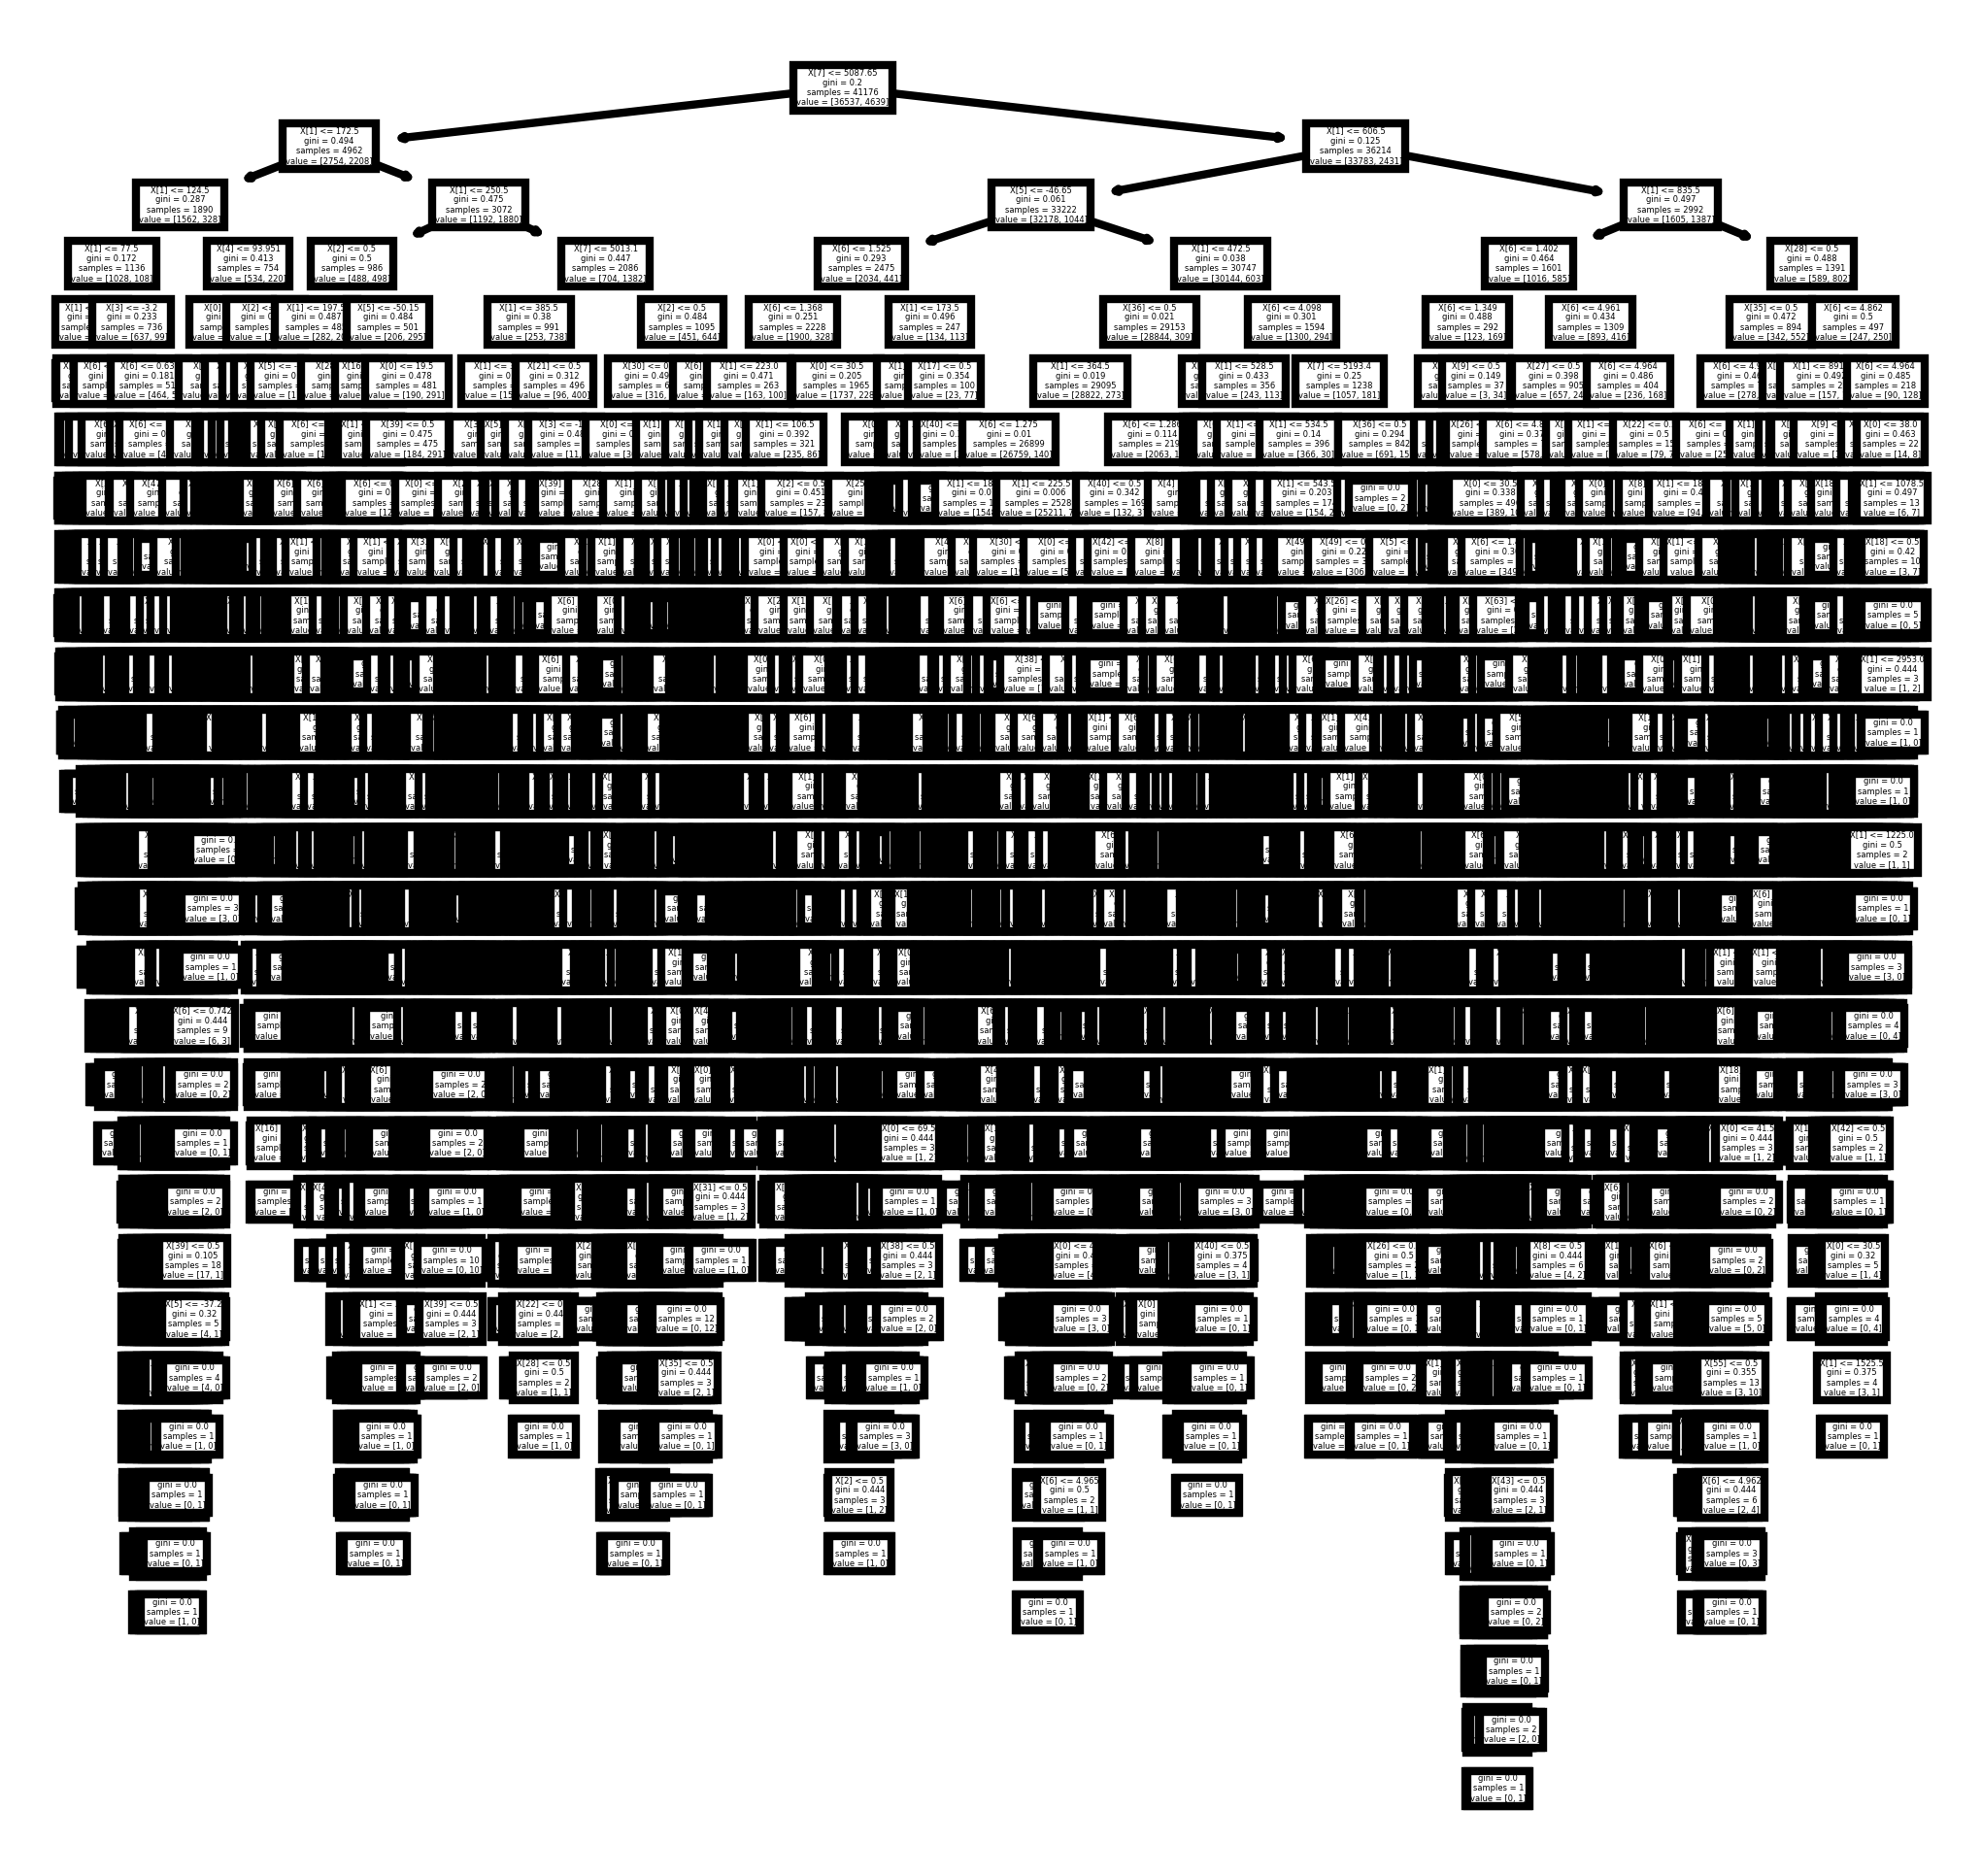

In [67]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=600)
tree.plot_tree(model)
fig.savefig('tree.png')

In [68]:
model.score(X,y)

1.0

# Train Test Split


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [70]:
X_test.shape

(8236, 83)

In [71]:
model=DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

# Evaluation

In [0]:
y_pred = model.predict(X_test)


In [73]:
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [74]:
accuracy_score(y_test, y_pred)

0.8872025254978144

In [75]:
precision_score(y_test, y_pred)

0.5225321888412017

In [76]:
recall_score(y_test, y_pred)

0.5015447991761071

In [77]:
f1_score(y_test, y_pred)

0.5118234366789279

# K-Folds Cross Validation

In [0]:
#@title
model=DecisionTreeClassifier()
scores = cross_validate(model, X, y, cv=5, scoring=('accuracy', 'average_precision', 'recall','f1'))

In [89]:
scores

{'fit_time': array([0.2945292 , 0.25690842, 0.32163477, 0.32583928, 0.26758981]),
 'score_time': array([0.01916456, 0.01732135, 0.01775002, 0.01714826, 0.01684809]),
 'test_accuracy': array([0.8890238 , 0.3623558 , 0.61165756, 0.14304797, 0.14219794]),
 'test_average_precision': array([0.12606241, 0.10490321, 0.10891446, 0.11196746, 0.11611612]),
 'test_f1': array([0.02972399, 0.02741248, 0.02201835, 0.00169755, 0.20807175]),
 'test_recall': array([0.01508621, 0.0798274 , 0.0387931 , 0.00646552, 1.        ])}

# Random Forest

In [0]:
rfc = RandomForestClassifier()
rfc_scores = cross_validate(rfc, X, y.values.ravel(), cv=5, scoring=('accuracy', 'average_precision', 'recall','f1'))

In [81]:
rfc_scores

{'fit_time': array([2.21283388, 2.62667012, 2.50782084]),
 'score_time': array([0.21448588, 0.27950692, 0.17086363]),
 'test_accuracy': array([0.8874399 , 0.18258652, 0.15140255]),
 'test_average_precision': array([0.13974699, 0.07412006, 0.07612234]),
 'test_f1': array([2.58231117e-03, 1.78237234e-04, 2.09783567e-01]),
 'test_recall': array([1.29282482e-03, 6.46830530e-04, 1.00000000e+00])}

In [0]:
report = pd.DataFrame(index=list(rfc_scores.keys())[2:], columns=['Decision Tree', 'Random Forest'])
for key in report.index:
  report.loc[key] = [np.mean(scores[key]), np.mean(rfc_scores[key])]

report['Improvment'] = report['Random Forest'] - report['Decision Tree']
report *= 100
report = report.astype(float).round(1)

In [93]:
report

,Decision Tree,Random Forest,Improvment
test_accuracy,43.0,44.7,1.7
test_average_precision,11.4,10.2,-1.1
test_recall,22.8,20.9,-1.9
test_f1,5.8,4.9,-0.9


# (Permutation) Feature Importance

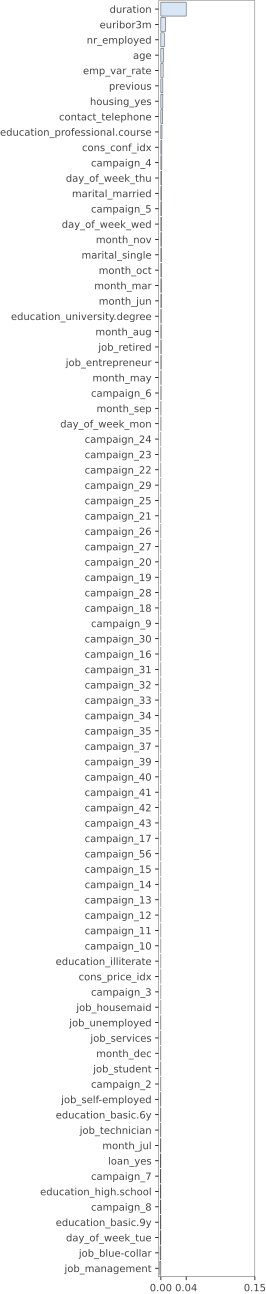

In [94]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train.values.ravel())
importance = rfpimp.importances(rfc, X_test, y_test)
rfpimp.plot_importances(importance)

**So, the most important feature is the duration of the calls.** We have learned from Bivariate Analysis: the longer the calls, the more successful. Followed by 2 social-economic indicators: The 3-months-Euribor-rate (interest rate) and the Number of (overall) employed people.

# Save Model

## Save Model

In [0]:
pickle.dump(rfc, open('RandomForestRegressor.model', 'wb'))